In [1]:
import sys
sys.path.append('../../')
import numpy as np
import stateinterpreter
from stateinterpreter import MetastableStates, Classifier
from stateinterpreter.plot import plot_states
from importlib import reload
reload(stateinterpreter.MD)
reload(stateinterpreter.classifier)
reload(stateinterpreter.plot)
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
chignolin_data_path = '../../../data/md_datasets/chignolin-unbiased/'
colvar_file = chignolin_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
# Compute descriptors from Trajectory
data = MetastableStates(colvar_file, kbt=2.8, stride=100)
data.load_trajectory(traj_dict)

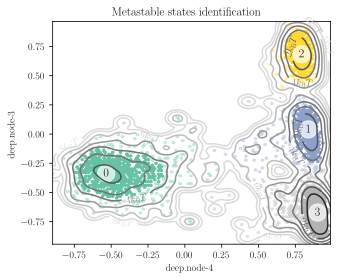

In [5]:
cv_list = ['deep.node-4', 'deep.node-3']
data.identify_metastable_states(cv_list, bw_method=0.07)
plot_states(data, fes_isolines=True);

In [5]:
import re
def get_residue(s):
    m = re.search(r'\w{3}\d+$', s)
    return m.group() if m else None

def _get_angle_groups(angle_names):
    groups = []
    for s in angle_names:
        groups.append(get_residue(s))
    return np.array(groups)

In [10]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'sin_|cos_'
states_names = [
    'Unfolded',
    'Folded Mid',
    'Folded High',
    'Folded Low'
]
sample, features_names, classes_names = data.sample(100, regex_filter = select_feat, states_names=states_names)
groups = _get_angle_groups(features_names)
classifier = Classifier(sample, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, groups=groups)

Group Lasso: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


State Unfolded:
	 45.582% | THR6
	 41.142% | ASP3
	 12.766% | THR8
	 0.432%  | TYR2
	 0.079%  | GLY7
State Folded Mid:
	 47.885% | THR6
	 36.386% | ASP3
	 15.34%  | THR8
	 0.324%  | TYR2
	 0.066%  | GLY7
State Folded High:
	 58.859% | THR6
	 39.923% | THR8
	 1.064%  | ASP3
	 0.133%  | GLY7
	 0.02%   | TYR2
State Folded Low:
	 59.376% | THR6
	 36.702% | THR8
	 3.774%  | ASP3
	 0.111%  | GLY7
	 0.037%  | TYR2


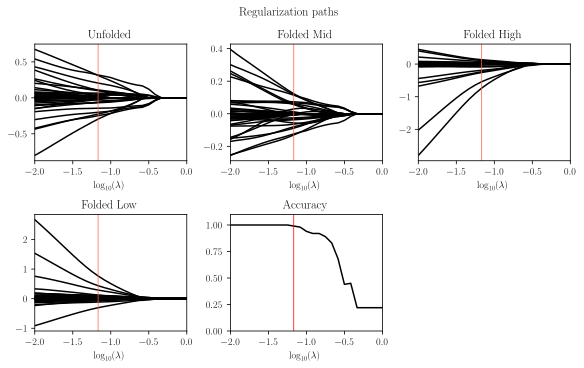

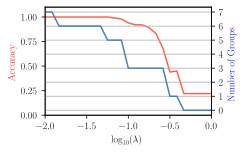

In [14]:
reg = 10**(-1.2)
classifier.print_selected(reg)
classifier.plot(reg);
classifier.plot_groups();

In [17]:
#classifier.prune(reg)
groups = _get_angle_groups(classifier.features)
classifier.compute(regularizers, max_iter = 100000, groups = groups)

Group Lasso: 100%|██████████| 25/25 [00:08<00:00,  3.04it/s]


A note on the problem to solve:
1. For regular Lasso $$ \min_{w}C\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \Vert w \Vert_{1}$$
2. For _group_ Lasso $$ \min_{w} \frac{1}{n}\sum_{i=1}^{n}\ell(\boldsymbol{x}_{i}, y_{i}, w) + \lambda \sum_{j}  \Vert w_{j} \Vert_{2}$$

To have everything consistent $C \mapsto (\lambda n)^{-1}$. I'll use $\lambda$ as regularization parameter.